# Installation check

This workbook has a simple example of a model fit with PyMC3.  If everything runs here then it should work fine in the workshop.

First, check that you have the right kernel.  It should say "bayes" in the top right next to the circle.  If it doesn't say "bayes", then go to the kernel menu and the "Change kernel" sub-menu. Select "bayes" from that menu.  If you still don't see "bayes" listed, close the notebook in the browser and command line, open a new terminal and run <python -m ipykernel install --user --name bayes --display-name "bayes">.  Try to open jupyter again.  Contact me if it still doesn't work.

Use <ctrl+enter> to run each cell or select `Run all` from the cell menu. It will take a couple of minutes for everything to run.  

When the notebook is running there will be a [*] next to In by each cell.  If the brackets are empty e.g. In [] then an error has occurred at some point in the notebook.  The plot at the bottom will load if everything runs successfully.


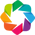

In [9]:
import numpy as np
import pandas as pd
import scipy
import xarray as xr

import pymc3 as pm
import theano.tensor as ttens
import sklearn 

import bokeh
import holoviews as hv
import matplotlib.pyplot as plt

hv.notebook_extension('bokeh')
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Create some fake data.

In [10]:
N = 100 # Number of data points in our idealised dataset
means = np.array([ 0 , 0]) # Mean values for our bivariate normal distribution
variances = np.array([1, 1]) # Variances for our bivariate normal distribution

# We will generate datasets with correlation - which we call rho - that ranges from -1 to 1
rho = 0.5

covariances = np.array( [[variances[0]**2,rho*variances[0]*variances[1]],[rho*variances[0]*variances[1], variances[1]**2]])
data = np.random.multivariate_normal( means, covariances, N)


Specify and compile a Stan model.  This step make take a couple of minutes.  You can go ahead and run the following cells while you wait so that you know when the compilation has finished.

In [11]:
def correlation(x, y, 
                mu_prior = {'mean': 0, 'sd': 1}, sigma_prior = {'sd':3}, 
                rho_prior = {'lower':-1,'upper':1}):
    """Get the correlation between x and y
    Inputs:
    x,y - numpy arrays/pandas series of same length
    priors for the parameters
    Ouputs:
    trace - PyMC3 output with results of inference
    rho_range - dictionary setting out mean rho and 95% range
    simulate_data - data simulated under the model
    output trace and summary dictionary"""
    # Check inputs are appropriate
    assert (len(x.shape)) & (len(y.shape)) == 1, "x and y should be 1D arrays, but x has shape {} and y has shape {}".format(x.shape, y.shape)
    assert len(x) == len(y), "x and y should be same length but x is {} and y is {}".format(len(x), len(y))
    assert ('mean' in mu_prior) and ('sd' in mu_prior), "mu_prior should have keys 'mean' and 'sd' but has {}".format(mu_prior.keys())
    assert 'sd' in sigma_prior, "sigma_prior should have key 'sd' but has {}".format(sigma_prior.keys())
    assert ('lower' in rho_prior) and ('upper' in rho_prior), "mu_prior should have keys 'mean' and 'sd' but has {}".format(mu_prior.keys())
    
    def covariance(sigma, rho):
        """Create the covariance matrix from the array sigma and scalar rho"""
        C = ttens.alloc(rho, 2, 2)
        C = ttens.fill_diagonal(C, 1.)
        S = ttens.diag(sigma)
        return ttens.nlinalg.matrix_dot(S, C, S)

    data = np.array([x,y]) # Create a single array with the observed dataset
    with pm.Model() as model:
        # Specify the priors for the means
        mu = pm.Normal('mu', mu = mu_prior['mean'], sd = mu_prior['sd'], shape = 2) 
        # Specify the priors for the variances
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'], shape = 2) 
        # Specify the priors for rho
        BoundedNormal = pm.Bound(pm.Normal, lower=np.array(-1.0), upper = np.array(1.0))
        rho = BoundedNormal('rho', mu=0.0, sd=1.0, testval = 0.5)
        #rho = Uniform('rho', lower = rho_prior['lower'], upper = rho_prior['upper']) 
        # Create the covariance matrix
        cov = pm.Deterministic('cov', covariance(sigma, rho)) 
        # Specify the likelihood as a multi-variate normal distribution
        mult_n = pm.MvNormal('mult_n', mu = mu, cov = cov, observed = data.T) 
        # Perform the inference and extract 1000 samples from the posterior distributions
        trace = pm.sample(draws = 1000) 
        # Save some summary statistics for each value of rho
        rho_range = {'mean':trace.get_values('rho').mean(),
                     '2.5':pm.stats.quantiles(trace)['rho'][2.5],
                     '97.5':pm.stats.quantiles(trace)['rho'][97.5]}
        # Simulate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return trace, rho_range, simulate_data


In [12]:
trace,out_dict, ppc = correlation(data[:,0],data[:,1]) 

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 766.35it/s]


In [13]:
ppc['mult_n'].shape

(1000, 2)

In [14]:
%%output size=120
%%opts Scatter (size=7,alpha=0.2) 
%%opts Histogram (alpha=0.5) 

# Set legend position
opts = {'Overlay': {'plot': dict(legend_position='top_left')}}
# Plot simulated model data
model_scatter = hv.Scatter(ppc['mult_n'],kdims=['x'], vdims=['y'], label = 'Simulated data')
# Plot real data
data_scatter = hv.Scatter((data[:,0],data[:,1]),kdims=['x'], vdims=['y'], label = 'Real data')
# Combine simulated and real data
overlay = model_scatter.hist(dimension=['x','y'])*data_scatter.hist(dimension=['x','y'])
# Output plot
overlay(opts)

:AdjointLayout
   :Overlay
      .Scatter.Simulated_data :Scatter   [x]   (y)
      .Scatter.Real_data      :Scatter   [x]   (y)
   :Overlay
      .Histogram.Simulated_data :Histogram   [y]   (y_frequency)
      .Histogram.Real_data      :Histogram   [y]   (y_frequency)
   :Overlay
      .Histogram.Simulated_data :Histogram   [x]   (x_frequency)
      .Histogram.Real_data      :Histogram   [x]   (x_frequency)

You should see a scatter plot with two histograms